- Layer（重みを行列にしただけで簡単に動いた）, Networkクラスを実装。
- 8つのパーセプトロン3層でネットワーク構築。
- ニューラルネットの学習では一つの重みが他へ影響を持つ可能性があるので、target_networkを使い分ける。
- 正則化項は下のレイヤーに関しても学習の際は抜けないように気をつけた。

In [5]:
import numpy as np
from numpy.random import rand
from numpy.random import randn
import copy
from matplotlib import pyplot as plt
%matplotlib inline

def sigmoid(x):
    return np.where(x < 0, np.exp(x) / (1 + np.exp(x)), 
                    1 / (1 + np.exp(-x)))

class Layer:
    def __init__(self, in_size, out_size, _lambda=1.0):
        self._in_size = in_size
        self._out_size = out_size
        self._weight = randn(in_size, out_size)
        self._lambda = _lambda
        self._last_X = None
        self._last_O = None
        
    def forward(self, X):
        self._last_X = X
        self._last_O = sigmoid(np.dot(X, self._weight)) # + np.tile(
            # self._lambda * np.sum(self._weight ** 2, axis=0), (X.shape[0], 1))
        return self._last_O
    
    # forwardで保持しておいた入力を用いて伝搬された値を掛けて学習
    def backward(self, pt, learning_rate=1e-5):
        self._weight -= np.sum(pt, axis=0) * (np.dot(self._last_X.T, self._last_O * (
            1 - self._last_O))) * learning_rate # + self._lambda * 2 * self._weight) * learning_rate
        
    def forward_over_partial_X(self):
        return np.dot(self._last_O * (
            1 - self._last_O), self._weight.T) 

    def nabla_w(self, O):
        return np.dot(self._last_X.T, (2 * (self._last_O - O)) * self._last_O * (
            1 - self._last_O)) # + self._lambda * 2 * self._weight
    
    def _nabla_w(self, O):
        return np.dot(self._last_X.T, (2 * (self._last_O - O)) * self._last_O * (
            1 - self._last_O))
    
    # 勾配確認用
    def numerical_nabla_w(self, O):
        eps = 1e-4
        nabla_w = np.zeros_like(self._weight)
        for i in range(self._in_size):
            tmp = self._weight[i]
            self._weight[i] = float(tmp) - eps
            lm = np.sum((sigmoid(np.dot(self._last_X, self._weight)) - O) ** 2)
            self._weight[i] = float(tmp) + eps
            lp = np.sum((sigmoid(np.dot(self._last_X, self._weight)) - O) ** 2)
            nabla_w[i] = (lp - lm) / (2 * eps)
            self._weight[i] = tmp
        return nabla_w
    
    def nabla_i(self, O):
        return np.dot(2 * (self._last_O - O) * self._last_O * \
                    (1 - self._last_O), self._weight.T)
        
    def learn(self, O, learning_rate=1e-5):
        self._weight -= self.nabla_w(O) * learning_rate
        # 数値計算版
        # self._weight -= self.numerical_nabla_w(o_star, X) * learning_rate
    
    # experience_replay用に更新せずマイナス分を出力する関数を用意
    def weight_diff_by_learn(self, O, learning_rate=1e-5):
        return self.nabla_w(O) * learning_rate
        
    def weight_diff_by_backward(self, pt, learning_rate=1e-5):
        return np.sum(pt, axis=0) * (np.dot(self._last_X.T, self._last_O * (
            1 - self._last_O))) * learning_rate #+ self._lambda * 2 * self._weight) * learning_rate

In [6]:
class Network:
    def __init__(self, layer_count, in_count, out_count, hidden_count):
        assert(layer_count > 2)
        self.layer_count = layer_count
        self.input_layer = Layer(in_count, hidden_count)
        self.hidden_layeres = []
        for i in range(layer_count - 2):
            self.hidden_layeres.append(Layer(hidden_count, hidden_count))
        self.output_layer = Layer(hidden_count, out_count)
        
    def predict(self, X):
        out = self.input_layer.forward(X)
        for i in range(self.layer_count - 2):
            out = self.hidden_layeres[i].forward(out)
        out = self.output_layer.forward(out)
        return out     
        
    def loss_function(self, X, O):
        out = self.predict(X)
        return np.sum((out - O) ** 2)
    
    def learn(self, X, O):
        self.output_layer.learn(O)
        di = self.output_layer.nabla_i(O)
        for i in range(self.layer_count - 2):
            self.hidden_layeres[self.layer_count - 3 - i].backward(di)
            di = self.hidden_layeres[self.layer_count - 3 - i].forward_over_partial_X()
        self.input_layer.backward(di)
        
    # experience_replay用に更新せずマイナス分を出力する関数とそれを受けて更新をかける関数を用意
    def get_weight_diff(self, X, O):
        diff_list = []
        diff_list.append(self.output_layer.weight_diff_by_learn(O))
        di = self.output_layer.nabla_i(O)
        for i in range(self.layer_count - 2):
            diff_list.append(self.hidden_layeres[self.layer_count - 3 - i].weight_diff_by_backward(di))
            di = self.hidden_layeres[self.layer_count - 3 - i].forward_over_partial_X()
        diff_list.append(self.input_layer.weight_diff_by_backward(di))
        return diff_list
    
    def update_weight_by_diff(self, weight_diff_list):
        self.output_layer._weight -= weight_diff_list[0]
        for i in range(self.layer_count - 2):
            self.hidden_layeres[self.layer_count - 3 - i]._weight -= weight_diff_list[i + 1]
        self.input_layer._weight -= weight_diff_list[-1]
        
    def test_grad(self, O):
        print(self.output_layer._nabla_w(O))
        print(self.output_layer.numerical_nabla_w(O))
        return np.linalg.norm(self.output_layer.nabla_w(O) - self.output_layer.numerical_nabla_w(O))

248.77501821936792
[[0.00281208]
 [0.01174954]]
[[0.00140061]
 [0.00578006]]
勾配確認： 0.006134072679737405
248.77500000971162
[[6.51719061e-05]
 [2.72344870e-04]]
[[2.72018497e-05]
 [4.21502477e-05]]
勾配確認： 0.00023330514178015741
248.77500000067988
[[1.76010672e-05]
 [7.35494170e-05]]
[[ 3.41685791e-06]
 [-5.72319436e-05]]
勾配確認： 0.00013154830326331663
248.7750000001858
[[9.30008503e-06]
 [3.88612788e-05]]
[[-7.33706429e-07]
 [-7.45723128e-05]]
勾配確認： 0.0001138764974054449
248.7750000000705
[[5.77858020e-06]
 [2.41459992e-05]]
[[-2.49443133e-06]
 [-8.19279933e-05]]
勾配確認： 0.00010639612117226558
248.77500000003226
[[3.93759513e-06]
 [1.64532226e-05]]
[[-3.41486839e-06]
 [-8.57730242e-05]]
勾配確認： 0.00010249031301155654
248.77500000001675
[[2.85470329e-06]
 [1.19282828e-05]]
[[-3.95630195e-06]
 [-8.80348239e-05]]
勾配確認： 0.00010019487255161573
248.77500000000953
[[2.16411283e-06]
 [9.04262702e-06]]
[[-4.30162572e-06]
 [-8.94769414e-05]]
勾配確認： 9.873151036721319e-05
248.7750000000058
[[1.69684775e-06

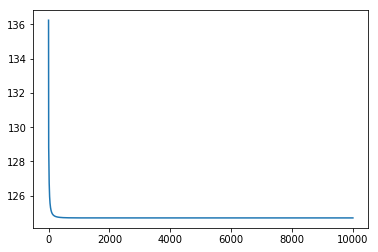

In [7]:
# Xor
# learning_rateを大きくするとすぐに振動する。
# 3層、入力2、出力1、隠れ層のパーセプトロン数2で実装。
# 収束が見られた。
X = rand(1000, 2)
test_X = rand(500, 2)
def Xor(X):
    _X = copy.deepcopy(X.T)
    _X[0] = X.T[0] > 0.5
    _X[1] = X.T[1] > 0.5
    return np.logical_xor(_X[0], _X[1]).astype(float).T.reshape(_X.shape[1], 1)
O = Xor(X)
test_O = Xor(test_X)

def train_network(network, X, O, learning_count=10000):
    learning_step = 0
    loss = np.empty(learning_count)
    while learning_count > learning_step:
        loss[learning_step] = network.loss_function(test_X, test_O)
        print(network.loss_function(X, O)) if learning_step % 1000 == 999 else network.loss_function(X, O) 
        print("勾配確認：", network.test_grad(O)) if learning_step % 1000 == 999 else None
        network.learn(X, O)   
        learning_step += 1
    plt.plot(loss)

network = Network(10, 2, 1, 2)
train_network(network, X, O)    

249.99100000233034
249.99100000015986
249.9910000000341
249.9910000000114
249.99100000000493
249.99100000000243
249.99100000000138
249.99100000000087
249.99100000000055
249.99100000000038


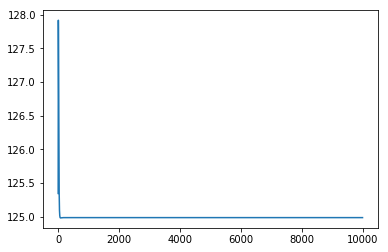

In [8]:
# Xor
# learning_rateを大きくするとすぐに振動する。
# 3層、入力2、出力1、隠れ層のパーセプトロン数2で実装。
# 収束が見られた。
X = rand(1000, 2)
test_X = rand(500, 2)
X = np.where(X > 0.5, 1.0, 0)
test_X = np.where(test_X > 0.5, 1.0, 0)
def Xor(X):
    _X = copy.deepcopy(X.T)
    _X[0] = X.T[0] > 0.5
    _X[1] = X.T[1] > 0.5
    return np.logical_xor(_X[0], _X[1]).astype(float).T.reshape(_X.shape[1], 1)
O = Xor(X)
test_O = Xor(test_X)

def train_network(network, X, O, learning_count=10000):
    learning_step = 0
    loss = np.empty(learning_count)
    while learning_count > learning_step:
        loss[learning_step] = network.loss_function(test_X, test_O)
        print(network.loss_function(X, O)) if learning_step % 1000 == 999 else network.loss_function(X, O) 
        #print("勾配確認：", network.test_grad(O)) if learning_step % 1000 == 999 else None
        network.learn(X, O)   
        learning_step += 1
    plt.plot(loss)

network = Network(10, 2, 1, 2)
train_network(network, X, O)    

In [9]:
import gym, gym.spaces
from copy import deepcopy
from collections import deque
import random

class DQN:
    def __init__(self, env, memory_count=100000):
        self.env = env
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.memory = deque(maxlen=memory_count)
        # 報酬が正の時のみ特別に保持したが、逆効果だった。
        # self.precious_meomory = deque(maxlen=memory_count)
        self.gamma = 0.9
        self.epsilon = 1.0
        self.learning_rate = 0.1
        self.model = self.build_network()
        self.target_model = deepcopy(self.model)
        
    def reset_memory(self, memory_count=100000):
        self.memory = deque(maxlen=memory_count)
        
    def build_network(self):
        # 8層、状態を入力とし、行動価値のベクトルを返す隠れ層のパーセプトロン数が3のネットワーク
        # チョット変えてみる
        return Network(5, self.state_size,  self.action_size, 300)

    def choose_action(self, state):
        if self.epsilon >= random.random():
            return self.env.action_space.sample()
        else:       
            return self.choose_best_action(state)

    def choose_best_action(self, state):
        state_v = np.zeros(self.state_size)
        state_v[state] = 1.0
        return np.argmax(self.model.predict(state_v))

    def replay_experience(self, batch_size):
        batch_size = min(batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)
        X = []
        O = []
        
        
        for i in range(len(minibatch)):
            o_star = np.zeros(self.action_size)
            o_star = np.zeros(self.action_size)
            state, action, reward, next_state, done = minibatch[i]
            state_v = np.zeros(self.state_size)
            state_v[state] = 1.0
            if done:
                o_star[action] -= self.learning_rate * (o_star[action] - reward)
            else:
                next_state_v = np.zeros(self.state_size)
                next_state_v[next_state] = 1.0
                o_star[action] -= self.learning_rate * (
                    o_star[action] - reward - self.gamma * max(
                        self.model.predict(next_state_v)))
            X.append(state_v)
            O.append(o_star)
            
            
        X = np.array(X)
        O = np.array(O)
        # forwardして更新
        self.model.predict(X)
        # modelで求めた勾配をtarget_modelにhannei
        self.target_model.update_weight_by_diff(self.model.get_weight_diff(X, O))

$Q(s_{t},a)\leftarrow Q(s_{t},a)+\alpha \left[r_{{t+1}}+\gamma \max _{p}Q(s_{{t+1}},p)-Q(s_{t},a)\right]$

```Python
Q[pre_state][action] -= learning_rate * (
                Q[pre_state][action] - reward -
                gamma * max(Q[state]))
```

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
%matplotlib inline

def plot_epsilon_and_reward(_epsilons, _rewards):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(_epsilons, 'C0', label='epsilon')

    ax2 = ax1.twinx()
    ax2.plot(_rewards,'C1', label='average reward')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='lower right')

    ax1.set_xlabel('time')
    ax1.set_ylabel('epsilon')
    ax1.grid(True)
    ax2.set_ylabel('average reward')
    ax1.get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))

In [11]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.cm as cm
import matplotlib.ticker as ticker

memory_count = 100000
episodes_c = 30000
exchange_time = 10
batch_size = 32
epsilons = deque(maxlen=episodes_c)
avg_rewards = deque(maxlen=episodes_c)
rewards = np.zeros(episodes_c)
sampling_rewards = deque(maxlen=exchange_time)
dqn_player = DQN(gym.make('Taxi-v2'), memory_count)
fp = widgets.FloatProgress(min=0, max=episodes_c)
display(fp)
for e in range(episodes_c):
    fp.value += 1
    state = dqn_player.env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dqn_player.choose_action(state)
        pre_state = state
        state, reward, done, info = dqn_player.env.step(action)
        total_reward += reward
#         if reward > 0:
#             dqn_player.precious_meomory.append((pre_state, action, reward, state, done))
        # 報酬をクリッピング
#         if 0 > reward:
#             reward = -1.0 
#         else:
#             reward = 1.0
        dqn_player.memory.append((pre_state, action, reward, state, done))

    sampling_rewards.append(total_reward)
    dqn_player.replay_experience(batch_size)
    
    rewards[e] = total_reward
    
    # 報酬の移動平均を求める。
    if len(sampling_rewards) >= exchange_time:
        epsilons.append(dqn_player.epsilon)
        avg_rewards.append(np.mean(sampling_rewards))
    
#     # ランダムな動きでメモリを溜め込んだら残りの回数はepsilonを線形に減らす。
#     if episodes_c // 2 < e and episodes_c - e - 1 != 0:
    if episodes_c - e - 1 != 0:
        dqn_player.epsilon -= dqn_player.epsilon / (episodes_c - e - 1)
        
    if e % exchange_time == exchange_time - 1:
        dqn_player.model = dqn_player.target_model
        # 新しい重みの状態でのデータを貯め直す
        dqn_player.reset_memory()
        
fp.close()

[2018-12-06 03:47:23,088] Making new env: Taxi-v2


FloatProgress(value=0.0, max=30000.0)

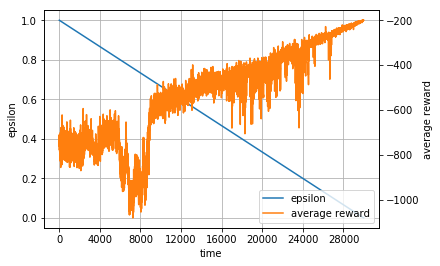

In [12]:
plot_epsilon_and_reward(epsilons, avg_rewards)

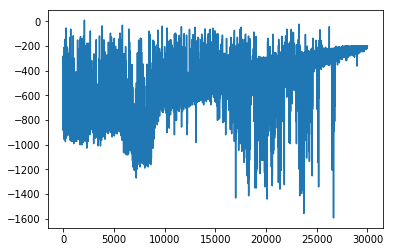

In [13]:
plt.plot(rewards)

In [17]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.cm as cm
import matplotlib.ticker as ticker

memory_count = 100000
episodes_c = 30000
exchange_time = 1000
batch_size = 32
epsilons = deque(maxlen=episodes_c)
avg_rewards = deque(maxlen=episodes_c)
rewards = np.zeros(episodes_c)
sampling_rewards = deque(maxlen=exchange_time)
dqn_player = DQN(gym.make('FrozenLake-v0'), memory_count)
fp = widgets.FloatProgress(min=0, max=episodes_c)
display(fp)
for e in range(episodes_c):
    fp.value += 1
    state = dqn_player.env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dqn_player.choose_action(state)
        pre_state = state
        state, reward, done, info = dqn_player.env.step(action)
        total_reward += reward
#         if reward > 0:
#             dqn_player.precious_meomory.append((pre_state, action, reward, state, done))
        # 報酬をクリッピング
        if 0 > reward:
            reward = -1.0 
        else:
            reward = 1.0
        dqn_player.memory.append((pre_state, action, reward, state, done))

    sampling_rewards.append(total_reward)
    dqn_player.replay_experience(batch_size)
    
    rewards[e] = total_reward
    
    # 報酬の移動平均を求める。
    if len(sampling_rewards) >= exchange_time:
        epsilons.append(dqn_player.epsilon)
        avg_rewards.append(np.mean(sampling_rewards))
    
#     # ランダムな動きでメモリを溜め込んだら残りの回数はepsilonを線形に減らす。
#     if episodes_c // 2 < e and episodes_c - e - 1 != 0:
    if episodes_c - e - 1 != 0:
        dqn_player.epsilon -= dqn_player.epsilon / (episodes_c - e - 1)
        
    if e % exchange_time == exchange_time - 1:
        dqn_player.model = dqn_player.target_model
        # 新しい重みの状態でのデータを貯め直す
        dqn_player.reset_memory()
        
fp.close()

[2018-12-07 14:12:17,507] Making new env: FrozenLake-v0


FloatProgress(value=0.0, max=30000.0)

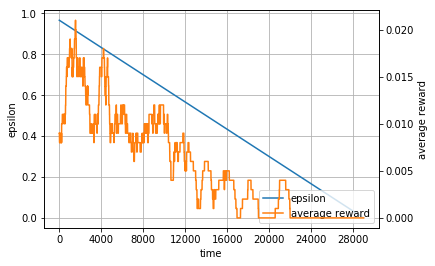

In [15]:
plot_epsilon_and_reward(epsilons, avg_rewards)

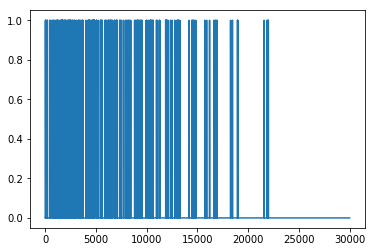

In [16]:
plt.plot(rewards)

[2018-12-05 11:25:51,682] Making new env: FrozenLake-v0


FloatProgress(value=0.0, max=5000.0)

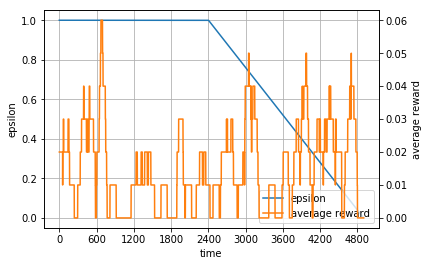

In [29]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.cm as cm
import matplotlib.ticker as ticker

memory_count = 100000
episodes_c = 5000
exchange_time = 100
batch_size = 32
epsilons = deque(maxlen=episodes_c)
avg_rewards = deque(maxlen=episodes_c)
sampling_rewards = deque(maxlen=exchange_time)
dqn_player = DQN(gym.make('FrozenLake-v0'), memory_count)
fp = widgets.FloatProgress(min=0, max=episodes_c)
display(fp)
for e in range(episodes_c):
    fp.value += 1
    state = dqn_player.env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dqn_player.choose_action(state)
        pre_state = state
        state, reward, done, info = dqn_player.env.step(action)
        total_reward += reward
#         if reward > 0:
#             dqn_player.precious_meomory.append((pre_state, action, reward, state, done))
        # 報酬をクリッピング
        if 0 > reward:
            reward = -1.0 
        else:
            reward = 1.0
        dqn_player.memory.append((pre_state, action, reward, state, done))

    sampling_rewards.append(total_reward)
    dqn_player.replay_experience(batch_size)
    
    # 報酬の移動平均を求める。
    if len(sampling_rewards) >= exchange_time:
        epsilons.append(dqn_player.epsilon)
        avg_rewards.append(np.mean(sampling_rewards))
    
#     # ランダムな動きでメモリを溜め込んだら残りの回数はepsilonを線形に減らす。
    if episodes_c // 2 < e and episodes_c - e - 1 != 0:
#     if episodes_c - e - 1 != 0:
        dqn_player.epsilon -= dqn_player.epsilon / (episodes_c - e - 1)
        
    if e % exchange_time == exchange_time - 1:
        dqn_player.model = dqn_player.target_model
        # 新しい重みの状態でのデータを貯め直す
        # dqn_player.reset_memory()
        
fp.close()
plot_epsilon_and_reward(epsilons, avg_rewards)

[2018-12-02 17:17:35,437] Making new env: FrozenLake-v0


FloatProgress(value=0.0, max=500000.0)

/Users/masahiromatsui/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


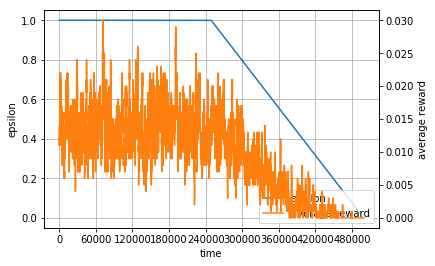

In [65]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.cm as cm
import matplotlib.ticker as ticker

memory_count = 100000
episodes_c = 500000
exchange_time = 1000
batch_size = 1024
epsilons = deque(maxlen=episodes_c)
avg_rewards = deque(maxlen=episodes_c)
sampling_rewards = deque(maxlen=exchange_time)
dqn_player = DQN(gym.make('FrozenLake-v0'), memory_count)
fp = widgets.FloatProgress(min=0, max=episodes_c)
display(fp)
for e in range(episodes_c):
    fp.value += 1
    state = dqn_player.env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dqn_player.choose_action(state)
        pre_state = state
        state, reward, done, info = dqn_player.env.step(action)
        total_reward += reward
#         if reward > 0:
#             dqn_player.precious_meomory.append((pre_state, action, reward, state, done))
        # 報酬をクリッピング
        if 0 > reward:
            reward = -1.0 
        else:
            reward = 1.0
        dqn_player.memory.append((pre_state, action, reward, state, done))

    sampling_rewards.append(total_reward)
    dqn_player.replay_experience(batch_size)
    
    # 報酬の移動平均を求める。
    if len(sampling_rewards) >= exchange_time:
        epsilons.append(dqn_player.epsilon)
        avg_rewards.append(np.mean(sampling_rewards))
    
#     # ランダムな動きでメモリを溜め込んだら残りの回数はepsilonを線形に減らす。
    if episodes_c // 2 < e and episodes_c - e - 1 != 0:
#     if episodes_c - e - 1 != 0:
        dqn_player.epsilon -= dqn_player.epsilon / (episodes_c - e - 1)
        
    if e % exchange_time == exchange_time - 1:
        dqn_player.model = dqn_player.target_model
        # 新しい重みの状態でのデータを貯め直す
        # dqn_player.reset_memory()
        
fp.close()
plot_epsilon_and_reward(epsilons, avg_rewards)

In [66]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.cm as cm
import matplotlib.ticker as ticker

memory_count = 100000
episodes_c = 500000
exchange_time = 1000
batch_size = 1024
epsilons = deque(maxlen=episodes_c)
avg_rewards = deque(maxlen=episodes_c)
sampling_rewards = deque(maxlen=exchange_time)
dqn_player = DQN(gym.make('FrozenLake-v0'), memory_count)
fp = widgets.FloatProgress(min=0, max=episodes_c)
display(fp)
for e in range(episodes_c):
    fp.value += 1
    state = dqn_player.env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dqn_player.choose_action(state)
        pre_state = state
        state, reward, done, info = dqn_player.env.step(action)
        total_reward += reward
#         if reward > 0:
#             dqn_player.precious_meomory.append((pre_state, action, reward, state, done))
        # 報酬をクリッピング
        if 0 > reward:
            reward = -1.0 
        else:
            reward = 1.0
        dqn_player.memory.append((pre_state, action, reward, state, done))

    sampling_rewards.append(total_reward)
    dqn_player.replay_experience(batch_size)
    
    # 報酬の移動平均を求める。
    if len(sampling_rewards) >= exchange_time:
        epsilons.append(dqn_player.epsilon)
        avg_rewards.append(np.mean(sampling_rewards))
    
#     # ランダムな動きでメモリを溜め込んだら残りの回数はepsilonを線形に減らす。
    if episodes_c // 2 < e and episodes_c - e - 1 != 0:
#     if episodes_c - e - 1 != 0:
        dqn_player.epsilon -= dqn_player.epsilon / (episodes_c - e - 1)
        
    if e % exchange_time == exchange_time - 1:
        dqn_player.model = dqn_player.target_model
        # 新しい重みの状態でのデータを貯め直す
        # dqn_player.reset_memory()
        
fp.close()
plot_epsilon_and_reward(epsilons, avg_rewards)

[2018-12-03 03:54:47,238] Making new env: FrozenLake-v0


FloatProgress(value=0.0, max=500000.0)

/Users/masahiromatsui/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


KeyboardInterrupt: 

In [ ]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.cm as cm
import matplotlib.ticker as ticker

memory_count = 100000
episodes_c = 500000
exchange_time = 1000
batch_size = 1024
epsilons = deque(maxlen=episodes_c)
avg_rewards = deque(maxlen=episodes_c)
sampling_rewards = deque(maxlen=exchange_time)
dqn_player = DQN(gym.make('FrozenLake-v0'), memory_count)
fp = widgets.FloatProgress(min=0, max=episodes_c)
display(fp)
for e in range(episodes_c):
    fp.value += 1
    state = dqn_player.env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dqn_player.choose_action(state)
        pre_state = state
        state, reward, done, info = dqn_player.env.step(action)
        total_reward += reward
#         if reward > 0:
#             dqn_player.precious_meomory.append((pre_state, action, reward, state, done))
        # 報酬をクリッピング
        if 0 > reward:
            reward = -1.0 
        else:
            reward = 1.0
        dqn_player.memory.append((pre_state, action, reward, state, done))

    sampling_rewards.append(total_reward)
    dqn_player.replay_experience(batch_size)
    
    # 報酬の移動平均を求める。
    if len(sampling_rewards) >= exchange_time:
        epsilons.append(dqn_player.epsilon)
        avg_rewards.append(np.mean(sampling_rewards))
    
#     # ランダムな動きでメモリを溜め込んだら残りの回数はepsilonを線形に減らす。
    if episodes_c // 2 < e and episodes_c - e - 1 != 0:
#     if episodes_c - e - 1 != 0:
        dqn_player.epsilon -= dqn_player.epsilon / (episodes_c - e - 1)
        
    if e % exchange_time == exchange_time - 1:
        dqn_player.model = dqn_player.target_model
        # 新しい重みの状態でのデータを貯め直す
        # dqn_player.reset_memory()
        
fp.close()
plot_epsilon_and_reward(epsilons, avg_rewards)

In [ ]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.cm as cm
import matplotlib.ticker as ticker

memory_count = 100000
episodes_c = 500000
exchange_time = 1000
batch_size = 1024
epsilons = deque(maxlen=episodes_c)
avg_rewards = deque(maxlen=episodes_c)
sampling_rewards = deque(maxlen=exchange_time)
dqn_player = DQN(gym.make('FrozenLake-v0'), memory_count)
fp = widgets.FloatProgress(min=0, max=episodes_c)
display(fp)
for e in range(episodes_c):
    fp.value += 1
    state = dqn_player.env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dqn_player.choose_action(state)
        pre_state = state
        state, reward, done, info = dqn_player.env.step(action)
        total_reward += reward
#         if reward > 0:
#             dqn_player.precious_meomory.append((pre_state, action, reward, state, done))
        # 報酬をクリッピング
        if 0 > reward:
            reward = -1.0 
        else:
            reward = 1.0
        dqn_player.memory.append((pre_state, action, reward, state, done))

    sampling_rewards.append(total_reward)
    dqn_player.replay_experience(batch_size)
    
    # 報酬の移動平均を求める。
    if len(sampling_rewards) >= exchange_time:
        epsilons.append(dqn_player.epsilon)
        avg_rewards.append(np.mean(sampling_rewards))
    
#     # ランダムな動きでメモリを溜め込んだら残りの回数はepsilonを線形に減らす。
    if episodes_c // 2 < e and episodes_c - e - 1 != 0:
#     if episodes_c - e - 1 != 0:
        dqn_player.epsilon -= dqn_player.epsilon / (episodes_c - e - 1)
        
    if e % exchange_time == exchange_time - 1:
        dqn_player.model = dqn_player.target_model
        # 新しい重みの状態でのデータを貯め直す
        # dqn_player.reset_memory()
        
fp.close()
plot_epsilon_and_reward(epsilons, avg_rewards)

[2018-12-01 13:28:03,149] Making new env: FrozenLake-v0


FloatProgress(value=0.0, max=2000.0)

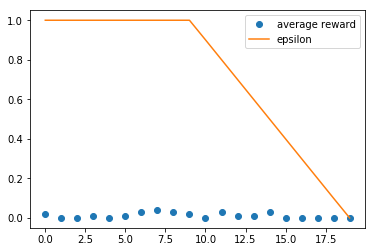

In [41]:
from IPython.display import display
import ipywidgets as widgets
memory_count = 10000
episodes_c = 2000
exchange_time = 100
batch_size = 1024
rewards_per_episode = []
rewards_per_episode_ave = []
epsilons = []
dqn_player = DQN(gym.make('FrozenLake-v0'), memory_count)
fp = widgets.FloatProgress(min=0, max=episodes_c)
display(fp)
for e in range(episodes_c):
    fp.value += 1
    state = dqn_player.env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dqn_player.choose_action(state)
        pre_state = state
        state, reward, done, info = dqn_player.env.step(action)
        total_reward += reward
        dqn_player.append_memory(pre_state, action, reward, state, done)
    rewards_per_episode.append(total_reward)
    dqn_player.replay_experience(batch_size)
    # ランダムな動きでメモリを溜め込んだら残りの回数はepsilonを線形に減らす。
    if episodes_c // 2 < e and episodes_c - e - 1 != 0:
        dqn_player.epsilon -= dqn_player.epsilon / (episodes_c - e - 1)
        
    if e % exchange_time == exchange_time - 1:
        rewards_per_episode_ave.append(sum(rewards_per_episode) / exchange_time)
        epsilons.append(dqn_player.epsilon)
        rewards_per_episode = []
        dqn_player.model = dqn_player.target_model
        
fp.close()
plt.plot(rewards_per_episode_ave, linestyle='None', marker='o', label="average reward")
plt.plot(epsilons, label="epsilon")
plt.legend()

In [215]:
dqn_player.env.step(3)



 

(2, 0.0, True, {'prob': 0.3333333333333333})

[2018-12-01 03:20:22,485] Making new env: Taxi-v2


FloatProgress(value=0.0, max=20000.0)

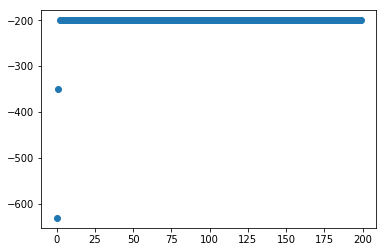

In [48]:
from IPython.display import display
import ipywidgets as widgets
episodes_c = 20000
exchange_time = 100
batch_size = 128
rewards_per_episode = []
rewards_per_episode_ave = []
dqn_player = DQN(gym.make('Taxi-v2'), episodes_c, exchange_time)
fp = widgets.FloatProgress(min=0, max=episodes_c)
display(fp)
for e in range(episodes_c):
    fp.value += 1
    state = dqn_player.env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dqn_player.choose_action(state)
        pre_state = state
        state, reward, done, info = dqn_player.env.step(action)
        total_reward += reward
        dqn_player.append_memory(pre_state, action, reward, state, done)
    rewards_per_episode.append(total_reward)
    dqn_player.replay_experience(batch_size)
    if e % exchange_time == exchange_time - 1:
        rewards_per_episode_ave.append(sum(rewards_per_episode) / exchange_time)
        rewards_per_episode = []
        dqn_player.model = dqn_player.target_model
        
fp.close()
plt.plot(rewards_per_episode_ave, linestyle='None', marker='o')

In [63]:
dqn_player = DQN(gym.make('FrozenLake-v0'), episodes_c, exchange_time)
dqn_player.e_decay

[2018-12-01 03:47:00,939] Making new env: FrozenLake-v0


0.01

In [56]:
len(deque(maxlen=10//2))

0

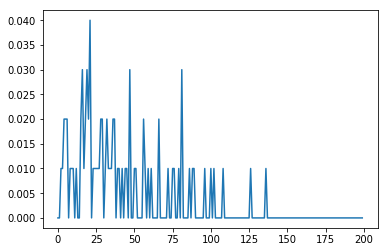

In [17]:
from IPython.display import display
import ipywidgets as widgets
dqn_player = DQN(gym.make('FrozenLake-v0'))
episodes_c = 20000
exchange_time = 100
batch_size = 128
rewards_per_episode = []
rewards_per_episode_ave = []
fp = widgets.FloatProgress(min=0, max=episodes_c)
display(fp)
for e in range(episodes_c):
    fp.value += 1
    state = dqn_player.env.reset()
    done = False
    total_reward = 0
    while not done:
        action = dqn_player.choose_action(state)
        pre_state = state
        state, reward, done, info = dqn_player.env.step(action)
        total_reward += reward
        dqn_player.append_memory(pre_state, action, reward, state, done)
    rewards_per_episode.append(total_reward)
    dqn_player.replay_experience(batch_size)
    if e % exchange_time == 0:
        rewards_per_episode_ave.append(sum(rewards_per_episode) / exchange_time)
        rewards_per_episode = []
        dqn_player.model = dqn_player.target_model
        
fp.close()
plt.plot(rewards_per_episode_ave)